In [1]:
#Causal Discovery for Allstate data
#@Saixiong Han

#provides data structures to quickly analyze data
#1.Read the train dataset

import pandas 
dataset = pandas.read_csv("C:/Study/assignment7/train.csv") 

print(dataset.shape)

#Drop the first column 'id' since it just has serial numbers. Not useful in the prediction process.
dataset = dataset.iloc[:,1:]

(188318, 132)


In [25]:
#Since the FGS and other algorithm only for all continues feature or category feature,
#We split the training data to continues dataset and category dataset
# sepearte the categorical and continous features
cont_columns = []
cat_columns = []

for i in dataset.columns:
    if dataset[i].dtype == 'float':
        cont_columns.append(i)
    elif dataset[i].dtype == 'object':
        cat_columns.append(i)

train_cat=dataset.iloc[:,0:115]
train_cont=dataset.iloc[:,116:]

In [26]:
# log transform the label variable
import numpy as np
train_cont['loss'] = np.log1p(train_cont['loss'])

In [27]:
#2.Data Overview &Normality Test
#Since the category feature can't make histogram and scatter plot,
#We choose the continues feature to make histogram for each ande scatter plot for each pair

import numpy
#import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

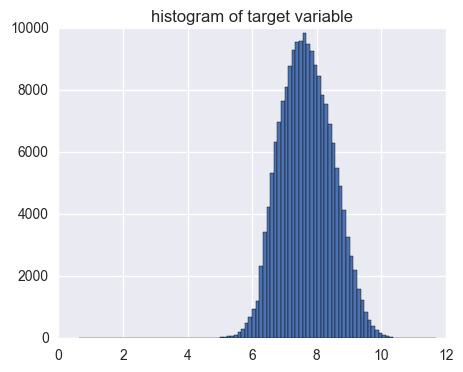

In [8]:
#Histogram of loss data

plt.figure(figsize=(5,4))
plt.hist(train_cont.loss, bins=100)
plt.title("histogram of target variable")
plt.show()

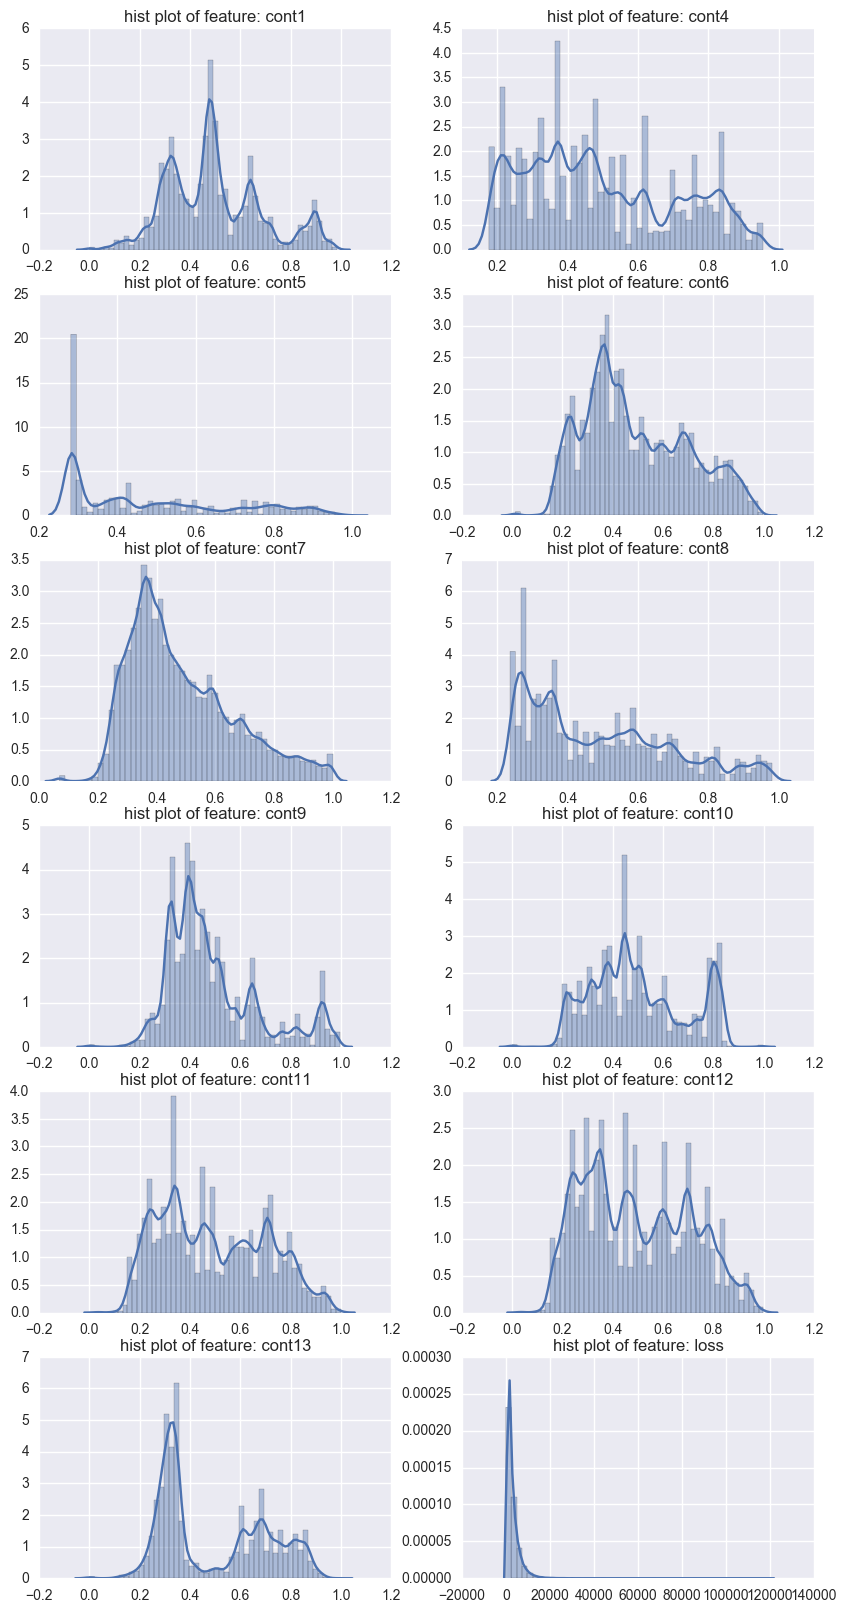

In [15]:
#Histogram of the other continues features whose skewness above 0.25
import matplotlib.gridspec as gridspec
from scipy import stats

skewness_list = []
for cn in dataset[cont_columns].columns:
    skewness_list.append(stats.skew(dataset[cn]))

skewed_cont_columns = []
for i, cn in enumerate(cont_columns):
    if skewness_list[i] >= 0.25:
        skewed_cont_columns.append(cn)

plt.figure(figsize=(10,20))
gs = gridspec.GridSpec(6, 2)
for i, cn in enumerate(skewed_cont_columns):
    ax = plt.subplot(gs[i])
    sns.distplot(dataset[cn], bins=50)
    ax.set_xlabel('')
    ax.set_title('hist plot of feature: ' + str(cn))
plt.show()

In [23]:
#con1, cont6, cont12 and cont13 show the tendency of normality violation. 
#Histograms of the four variable are all positive/right skewness.
#We can also check their skewness and normal test

In [28]:
# Skewness of the distribution
print(train_cont.skew())

# Values close to 0 show less ske
# loss shows the highest skew,cont9 also shows high skew
#Excpet these two features, the others sknew are around 0.5. which is tolerable range

cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
loss      0.096620
dtype: float64


In [29]:
#normality test

skewness_list = []
for cn in dataset[cont_columns].columns:
    print stats.mstats.normaltest(dataset[cn])

NormaltestResult(statistic=7535.3322273917556, pvalue=0.0)
NormaltestResult(statistic=28274.420088253744, pvalue=0.0)
NormaltestResult(statistic=6311.8789676806064, pvalue=0.0)
NormaltestResult(statistic=41079.995981999447, pvalue=0.0)
NormaltestResult(statistic=35226.741115360383, pvalue=0.0)
NormaltestResult(statistic=19350.127203540487, pvalue=0.0)
NormaltestResult(statistic=16580.463124422316, pvalue=0.0)
NormaltestResult(statistic=16457.792786104612, pvalue=0.0)
NormaltestResult(statistic=26254.401352670062, pvalue=0.0)
NormaltestResult(statistic=24224.641370997302, pvalue=0.0)
NormaltestResult(statistic=59705.672015603785, pvalue=0.0)
NormaltestResult(statistic=53198.631235554676, pvalue=0.0)
NormaltestResult(statistic=masked, pvalue=1.0)
NormaltestResult(statistic=masked, pvalue=1.0)
NormaltestResult(statistic=166643.90564318886, pvalue=0.0)


c:\python27\lib\site-packages\scipy\stats\mstats_basic.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  term2 = ma.power((1-2.0/A)/denom,1/3.0)


In [30]:
#From the normality test we can see, most pvalue equals to 0.
#cont12 and cont13 statistics are masked and their pvalue equals to 1.

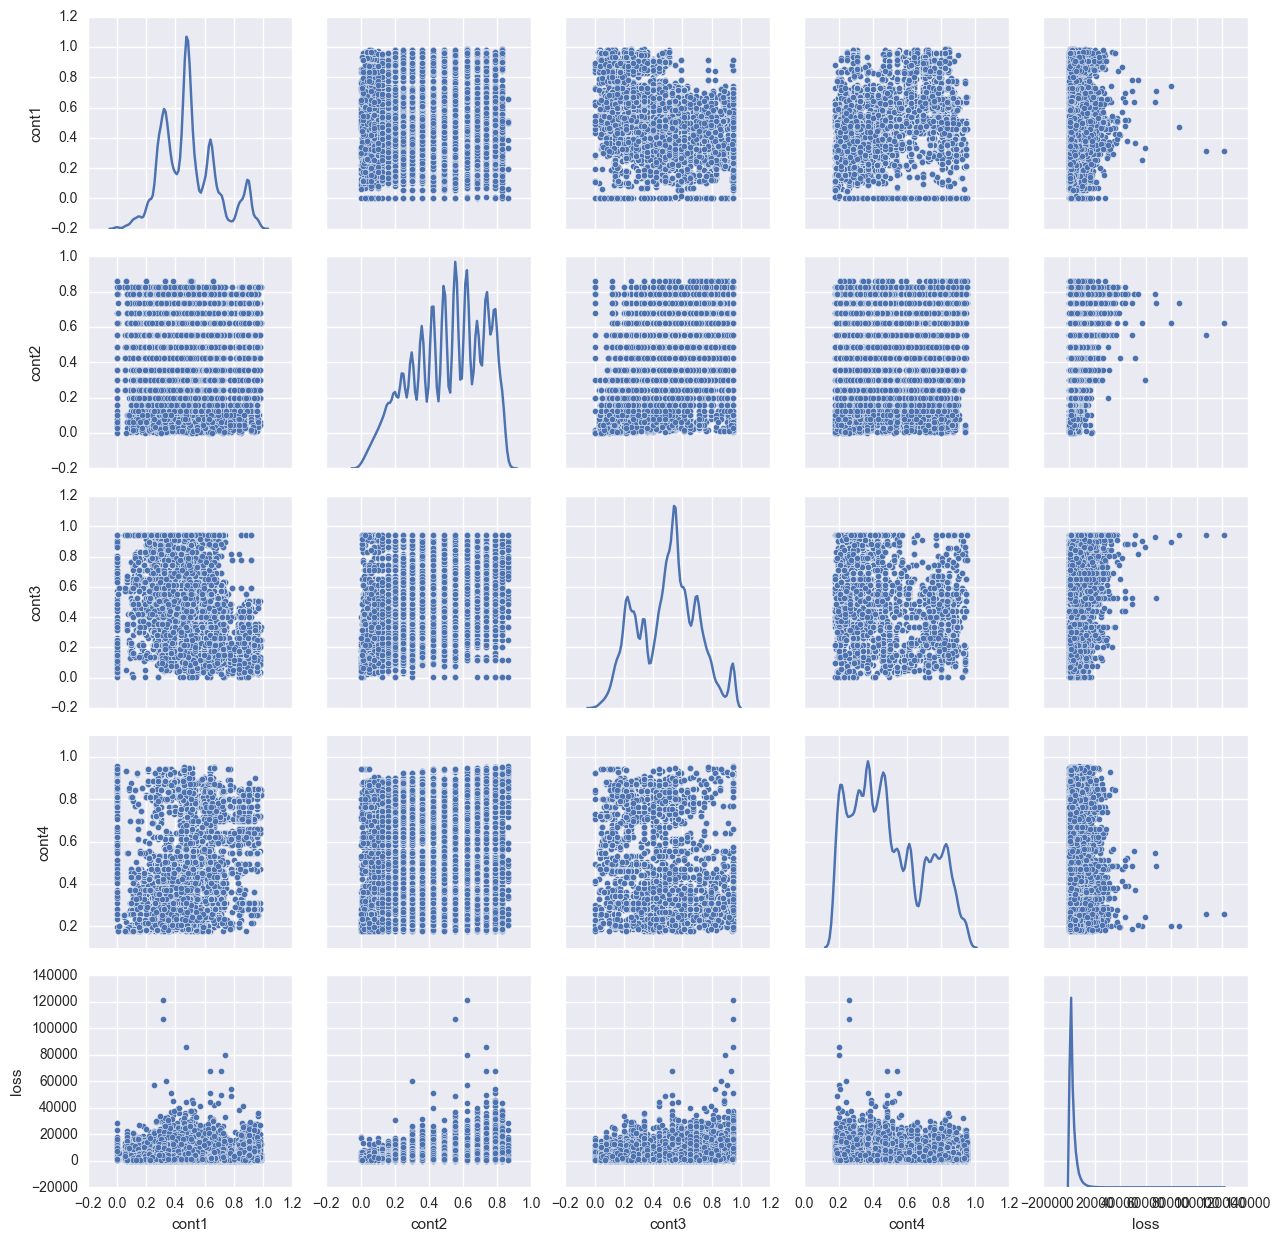

In [32]:
#3.Preprocessing
#Deleting scatter pattern outliers cannot fix the non-normal problem.
#Scatter plot for cont1,2,3,4 and loss
sns.pairplot(dataset[cont_columns], vars=['cont1','cont2','cont3','cont4','loss'], kind = 'scatter',diag_kind='kde')

In [33]:
#Since these scatter didn't show any obvious linear relation,we can't spell which point we should delete

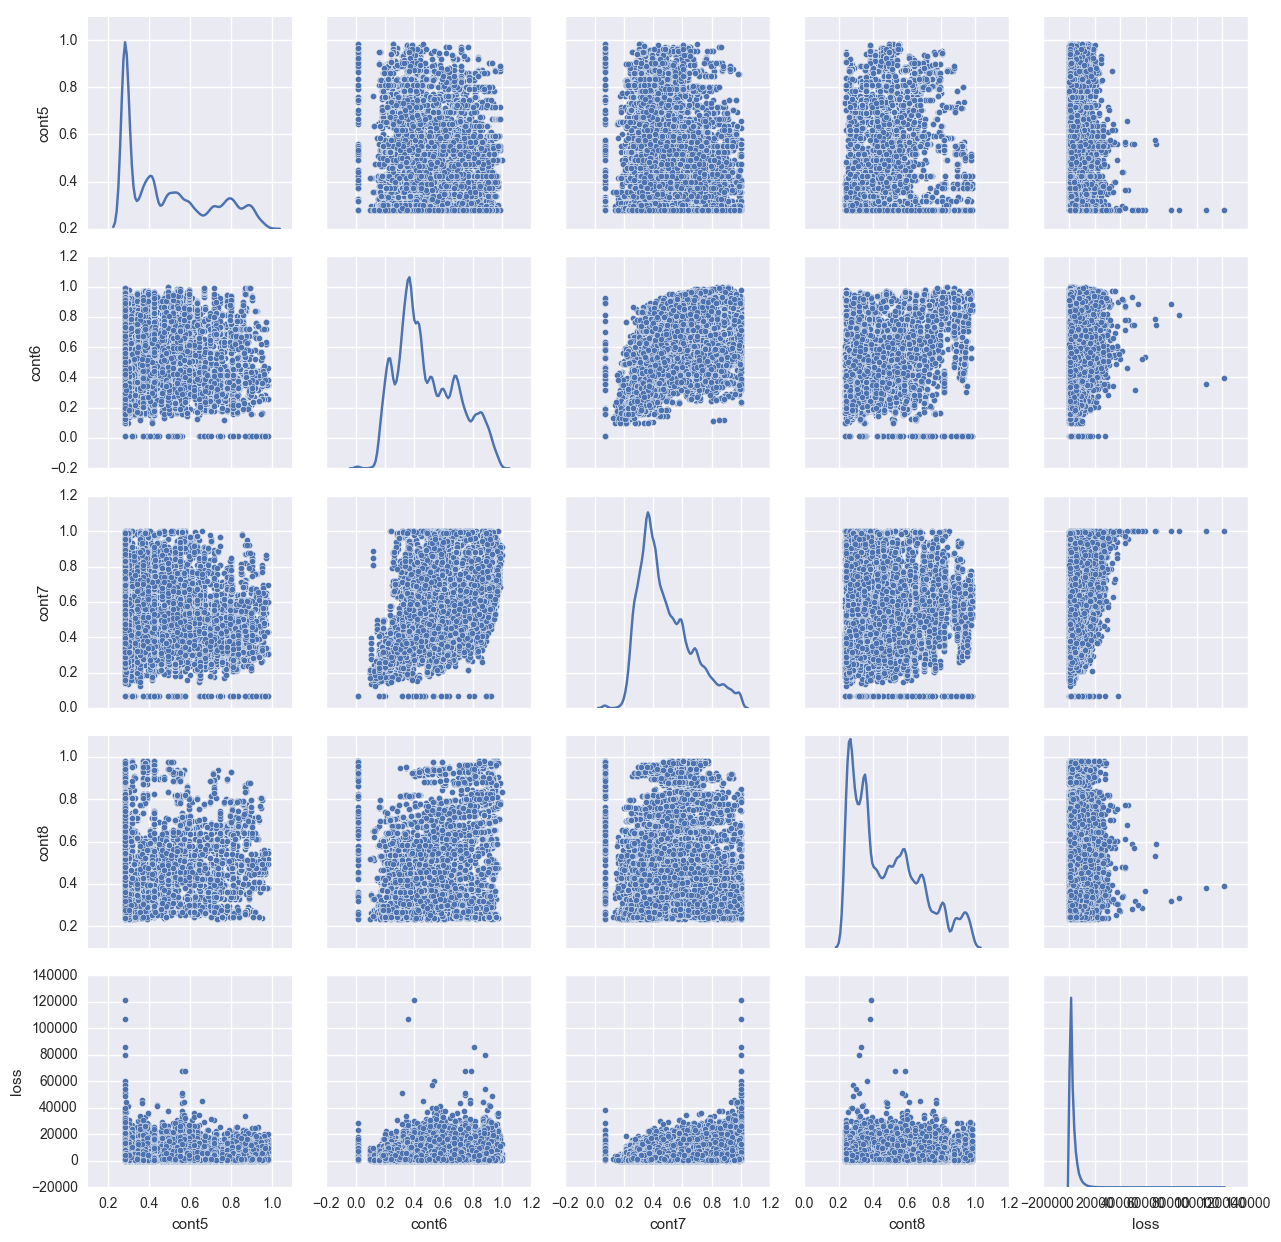

In [34]:
#Scatter plot for cont5,6,7,8 and loss
sns.pairplot(dataset[cont_columns], vars=['cont5','cont6','cont7','cont8','loss'], kind = 'scatter',diag_kind='kde')

In [ ]:
#Still no obvious linear relation shows in the graph.

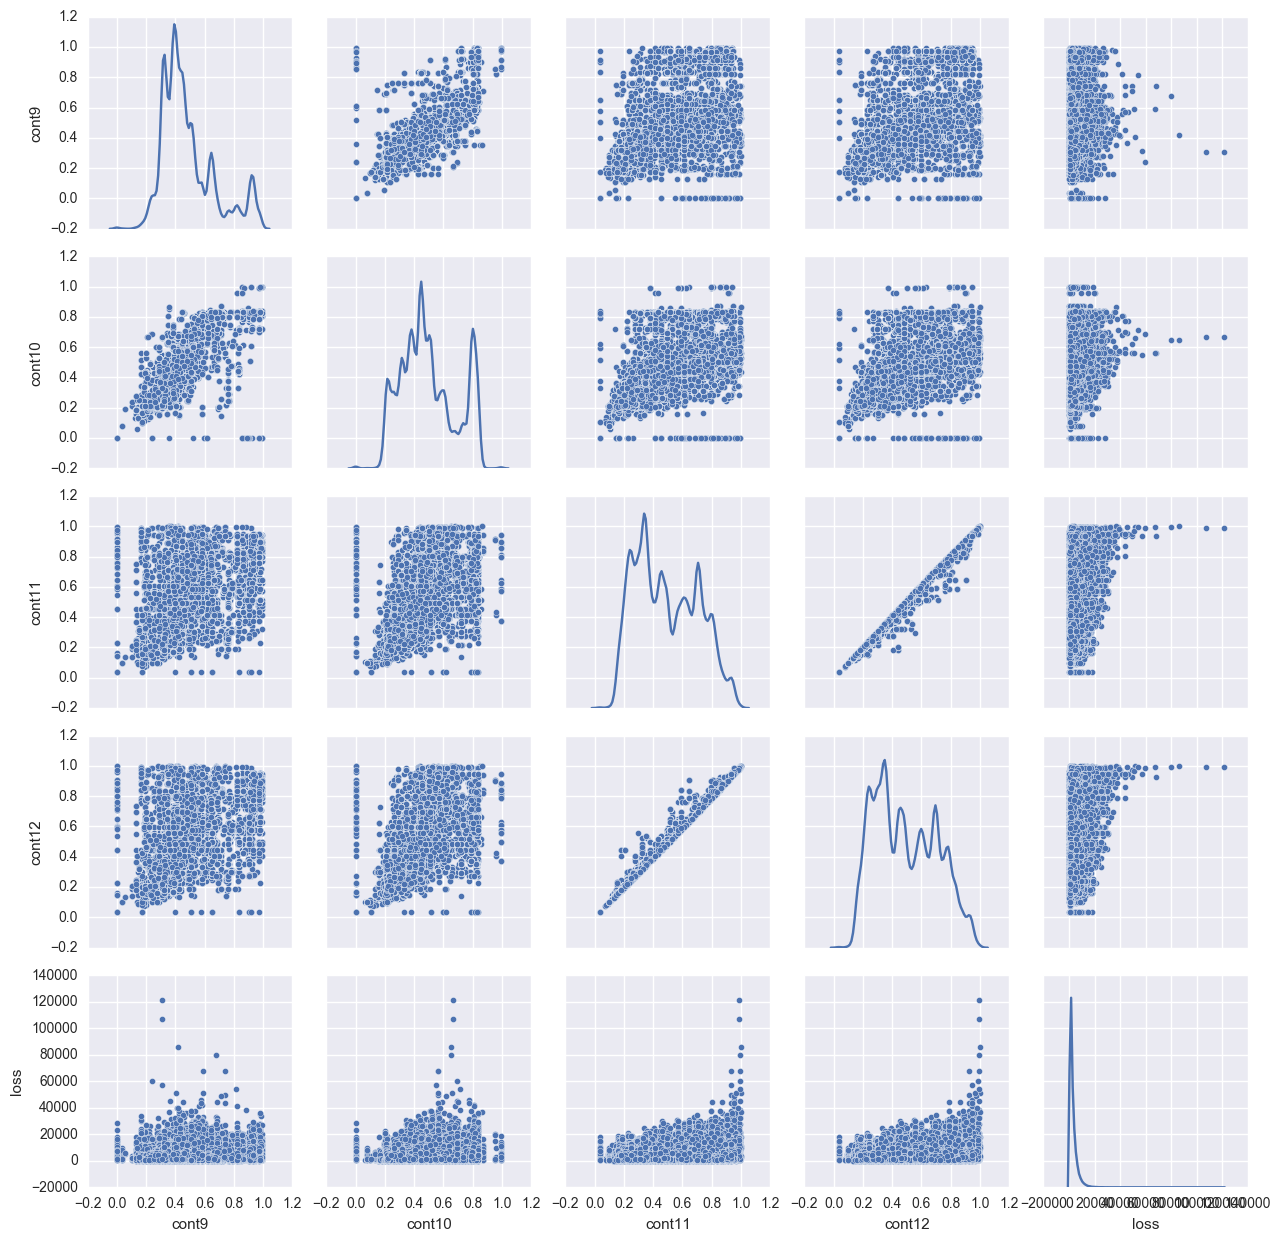

In [35]:
#Scatter plot for cont9,10,11,12 and loss
sns.pairplot(dataset[cont_columns], vars=['cont9','cont10','cont11','cont12','loss'], kind = 'scatter',diag_kind='kde')

In [36]:
#cont11 and cont12 shows very obvious linear relation.
#But all the points are close to the line, it's hard to identify a0n outlier in them.
#Still don't delete points.

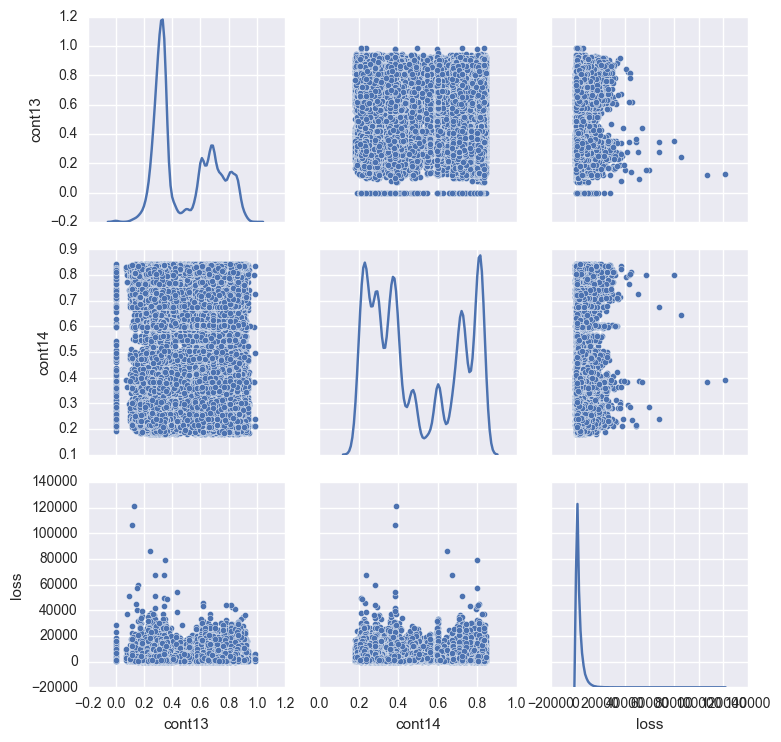

In [38]:
sns.pairplot(dataset[cont_columns], vars=['cont13','cont14','loss'], kind = 'scatter',diag_kind='kde')

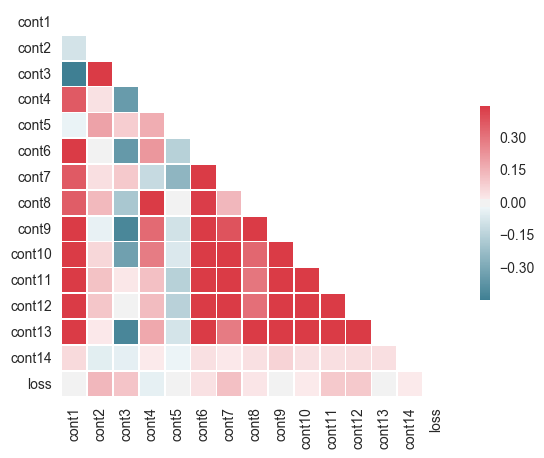

In [42]:
# Compute the correlation matrix for raw data
corr = dataset[cont_columns].corr()

sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [44]:
#4.Repeat Druzdzel &Glymour(1994) suggested model
#Generate DAG with PC algorithm
